In [25]:
import os
import PIL
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU, Input
import matplotlib.pyplot as plt

In [26]:
GCS_PATH = "C:\\Users\\Kenji\\OneDrive\\Documents\\Intro to ML\\Week 5"
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_jpg/*.jpg'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg'))

In [3]:
print('Monet jpg Files:', len(MONET_FILENAMES))
print('Photo jpg Files:', len(PHOTO_FILENAMES))

Monet jpg Files: 300
Photo jpg Files: 7038


Monet image shape: (256, 256, 3)
Photo image shape: (256, 256, 3)
AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'


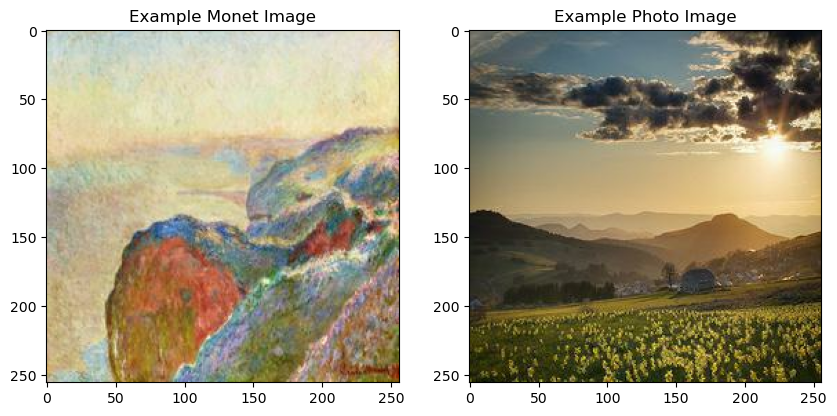

In [4]:
if MONET_FILENAMES and PHOTO_FILENAMES:
    example_monet_path = MONET_FILENAMES[0]
    monet_image = tf.io.read_file(example_monet_path)
    monet_image = tf.image.decode_jpeg(monet_image, channels=3)
    print("Monet image shape:", monet_image.shape)

    example_photo_path = PHOTO_FILENAMES[0]
    photo_image = tf.io.read_file(example_photo_path)
    photo_image = tf.image.decode_jpeg(photo_image, channels=3)
    print("Photo image shape:", photo_image.shape)
    
    # Display the images side by side
    plt.figure(figsize=(10, 5)) 

    # Show Monet image in the first subplot
    plt.subplot(1, 2, 2)
    plt.imshow(photo_image.numpy())
    plt.title("Example Photo Image")

    # Show Photo image in the second subplot
    plt.subplot(1, 2, 1)
    plt.imshow(monet_image.numpy())
    plt.title("Example Monet Image")

    plt.show()

In [5]:
IMAGE_SIZE = [256, 256]
# This function is responsible for loading, decoding
# normalizing, and reshaping an image from a given file path.
def decode_image(image_path):
    image = tf.io.read_file(image_path) # loads image as binary string from image path
    image = tf.image.decode_jpeg(image, channels=3) # decodes jpeg image into a TF tensor with 3 color channels
    image = (tf.cast(image, tf.float32)/127.5) - 1 # image tensor to tf.float32; Scaling pixel values
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # Ensures shape of (256, 256, 3)
    return image

In [6]:
monet_ds = tf.data.Dataset.from_tensor_slices(MONET_FILENAMES)
photo_ds = tf.data.Dataset.from_tensor_slices(PHOTO_FILENAMES)

In [7]:
monet_ds = monet_ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
photo_ds = photo_ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
BATCH_SIZE = 1 
monet_ds = monet_ds.shuffle(len(MONET_FILENAMES)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
photo_ds = photo_ds.shuffle(len(PHOTO_FILENAMES)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Generator 

In [9]:
def build_generator():
    inputs = Input(shape=(256, 256, 3))
    
    # Downsampling layers
    x = Conv2D(32, (7, 7), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    for _ in range(1):
        x = Conv2D(64, (3, 3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

    # Residual blocks
    # Adds residual connections to prevent information loss during deep learning.
    for _ in range(2):
        res = Conv2D(64, (3, 3), padding='same')(x)
        res = BatchNormalization()(res)
        res = ReLU()(res)
        res = Conv2D(64, (3, 3), padding='same')(res)
        res = BatchNormalization()(res)
        x = tf.keras.layers.Add()([x, res])
    
    # Upsampling layers
    for _ in range(1):
        x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
    
    x = Conv2D(3, (7, 7), padding='same', activation='tanh')(x)
    return keras.Model(inputs, x, name="Generator")

# Discriminator
def build_discriminator():
    inputs = Input(shape=(256, 256, 3))

    # Downsampling
    x = Conv2D(32, (4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU(negative_slope=0.2)(x)

    
    for filters in [64, 128]:
        x = Conv2D(filters, (4, 4), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(negative_slope=0.2)(x)
    
    x = Conv2D(1, (4, 4), padding='same')(x)
    return keras.Model(inputs, x, name="Discriminator")

## Loss

In [10]:
# Loss functions
loss_object = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return loss_object(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Cycle consistency loss
def cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

In [11]:
class CycleGAN:
    def __init__(self, learning_rate=0.0002, beta_1=0.5):
        # Initialize models
        self.models = {
            "generator_G": build_generator(),  # Generator: Converts Real photo → Monet-style
            "generator_F": build_generator(),  # Generator: Converts Monet-style → Real photo
            "discriminator_X": build_discriminator(),  # Discriminator: Checks if photo is real
            "discriminator_Y": build_discriminator()  # Discriminator: Checks if Monet painting is real
        }
        
        # Initialize optimizers
        self.optimizers = {
            "gen_G": keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1), # Optimizer for Generator_G
            "gen_F": keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1), # Optimizer for Generator_F
            "disc_X": keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1), # Optimizer for Discriminator_X
            "disc_Y": keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1) # Optimizer for Discriminator_Y
        }

    # Training one batch
    def train_step(self, real_X, real_Y):
        with tf.GradientTape(persistent=True) as tape:
            #Generate Fake and Cycled Images
            fake_Y = self.models["generator_G"](real_X, training=True)
            cycled_X = self.models["generator_F"](fake_Y, training=True)
            
            fake_X = self.models["generator_F"](real_Y, training=True)
            cycled_Y = self.models["generator_G"](fake_X, training=True)

            # Compute Discriminator Outputs
            real_output_X = self.models["discriminator_X"](real_X, training=True)
            fake_output_X = self.models["discriminator_X"](fake_X, training=True)
            
            real_output_Y = self.models["discriminator_Y"](real_Y, training=True)
            fake_output_Y = self.models["discriminator_Y"](fake_Y, training=True)

            # Compute Losses
            gen_G_loss = generator_loss(fake_output_Y) + cycle_loss(real_X, cycled_X)
            gen_F_loss = generator_loss(fake_output_X) + cycle_loss(real_Y, cycled_Y)
            
            disc_X_loss = discriminator_loss(real_output_X, fake_output_X)
            disc_Y_loss = discriminator_loss(real_output_Y, fake_output_Y)

        # Computed gradients of losses w.r.t. model parameters
        gradients = {
            "gen_G": tape.gradient(gen_G_loss, self.models["generator_G"].trainable_variables),
            "gen_F": tape.gradient(gen_F_loss, self.models["generator_F"].trainable_variables),
            "disc_X": tape.gradient(disc_X_loss, self.models["discriminator_X"].trainable_variables),
            "disc_Y": tape.gradient(disc_Y_loss, self.models["discriminator_Y"].trainable_variables)
        }

        # Applies gradient updates using the respective Adam optimizer        
        for key, grads in gradients.items():
            valid_grads = [(grad, var) for grad, var in zip(grads, self.models[key.replace("gen_", "generator_").replace("disc_", "discriminator_")].trainable_variables) if grad is not None]
            self.optimizers[key].apply_gradients(valid_grads)
        
        return gen_G_loss, gen_F_loss, disc_X_loss, disc_Y_loss

    # Trains CycleGAN model over multiple epochs
    def train(self, dataset_X, dataset_Y, epochs):
        for epoch in range(epochs):
            for real_X, real_Y in zip(dataset_X, dataset_Y):
                gen_G_loss, gen_F_loss, disc_X_loss, disc_Y_loss = self.train_step(real_X, real_Y)
            print(f"Epoch {epoch+1}, Gen G Loss: {gen_G_loss.numpy()}, Gen F Loss: {gen_F_loss.numpy()}, Disc X Loss: {disc_X_loss.numpy()}, Disc Y Loss: {disc_Y_loss.numpy()}")

In [12]:
cycle_gan = CycleGAN(learning_rate=0.0002, beta_1=0.5)
cycle_gan.train(photo_ds, monet_ds, epochs=20)

Epoch 1, Gen G Loss: 1.3429927825927734, Gen F Loss: 1.6519954204559326, Disc X Loss: 1.2575881481170654, Disc Y Loss: 1.2655476331710815
Epoch 2, Gen G Loss: 1.0375899076461792, Gen F Loss: 1.3381078243255615, Disc X Loss: 1.3099044561386108, Disc Y Loss: 1.2835804224014282
Epoch 3, Gen G Loss: 1.5076268911361694, Gen F Loss: 1.3314778804779053, Disc X Loss: 1.2576955556869507, Disc Y Loss: 0.6790038347244263
Epoch 4, Gen G Loss: 1.930521011352539, Gen F Loss: 1.0653021335601807, Disc X Loss: 1.132515788078308, Disc Y Loss: 0.9669142961502075
Epoch 5, Gen G Loss: 1.3610938787460327, Gen F Loss: 0.9914138317108154, Disc X Loss: 1.3597431182861328, Disc Y Loss: 0.5777380466461182
Epoch 6, Gen G Loss: 2.639298915863037, Gen F Loss: 1.3101983070373535, Disc X Loss: 1.2150746583938599, Disc Y Loss: 0.3285233974456787
Epoch 7, Gen G Loss: 0.9995483160018921, Gen F Loss: 1.233254075050354, Disc X Loss: 1.083317756652832, Disc Y Loss: 1.7359787225723267
Epoch 8, Gen G Loss: 1.3161171674728394

In [22]:
image_folder = "../images"
zip_filename = "C:\\Users\\Kenji\\OneDrive\\Documents\\Intro to ML\\Week 5"

if not os.path.exists(image_folder):
    os.makedirs(image_folder)

i = 1
for img_batch in photo_ds:
    img = tf.squeeze(img_batch, axis=0) 
    img = tf.expand_dims(img, axis=0)
    prediction = cycle_gan.models["generator_G"](img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(os.path.join(image_folder, f"{i}.jpg"))
    i += 1

shutil.make_archive(zip_filename, 'zip', os.path.dirname(image_folder), os.path.basename(image_folder))

'C:\\Users\\Kenji\\OneDrive\\Documents\\Intro to ML\\Week 5.zip'